# Predicting Chronic Kidney Disease based on health records
Given 24 health related attributes taken in 2-month period of 400 patients, using the information of the 158 patients with complete records to predict the outcome (i.e. whether one has chronic kidney disease) of the remaining 242 patients (with missing values in their records).


## Load Modules and helper functions

In [3]:
#Make necessary imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os, sys
import lux
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set()

## Load files

In [4]:
df = pd.read_csv('kidney_disease.csv')
df.head(n=10)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd
5,5,60.0,90.0,1.015,3.0,0.0,NaN,NaN,notpresent,notpresent,...,39,7800,4.4,yes,yes,no,good,yes,no,ckd
6,6,68.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,...,36,NaN,NaN,no,no,no,good,no,no,ckd
7,7,24.0,NaN,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,...,44,6900,5,no,yes,no,good,yes,no,ckd
8,8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,...,33,9600,4.0,yes,yes,no,good,no,yes,ckd
9,9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,...,29,12100,3.7,yes,yes,no,poor,no,yes,ckd


In [5]:
df.shape

(400, 26)

In [31]:
#find null Values in the data set

df.isnull().sum()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [7]:
# Impuing Null values

from sklearn.impute import SimpleImputer
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

df_imputed=pd.DataFrame(imp_mode.fit_transform(df))
df_imputed.columns=df.columns
df_imputed

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [8]:

df_imputed.isnull().sum()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [9]:
# Finding Unique values in the columns

for i in df_imputed.columns:
    print("*************************************************",i,"************************************************************")
    print()
    print(set(df_imputed[i].tolist()))
    print()

************************************************* id ************************************************************

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,

In [10]:
df_imputed["classification"]=df_imputed["classification"].apply(lambda x:'ckd' if x=="ckd\t"  else x)

Axes(0.125,0.11;0.775x0.77)


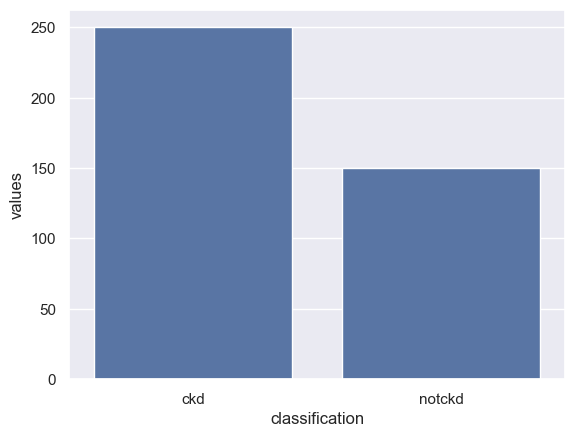

In [11]:
#Check Label Imbalance

import matplotlib.pyplot as plt
import seaborn as sns

temp=df_imputed["classification"].value_counts()
temp_df= pd.DataFrame({'classification': temp.index,'values': temp.values})
print(sns.barplot(x = 'classification', y="values", data=temp_df))

In [12]:
df.dtypes

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object


In [13]:
# fixing data types

df_imputed.dtypes

id                object
age               object
bp                object
sg                object
al                object
su                object
rbc               object
pc                object
pcc               object
ba                object
bgr               object
bu                object
sc                object
sod               object
pot               object
hemo              object
pcv               object
wc                object
rc                object
htn               object
dm                object
cad               object
appet             object
pe                object
ane               object
classification    object
dtype: object


In [14]:
for i in df.select_dtypes(exclude=["object"]).columns:
    df_imputed[i]=df_imputed[i].apply(lambda x: float(x))

In [15]:
df_imputed.dtypes

id                float64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object


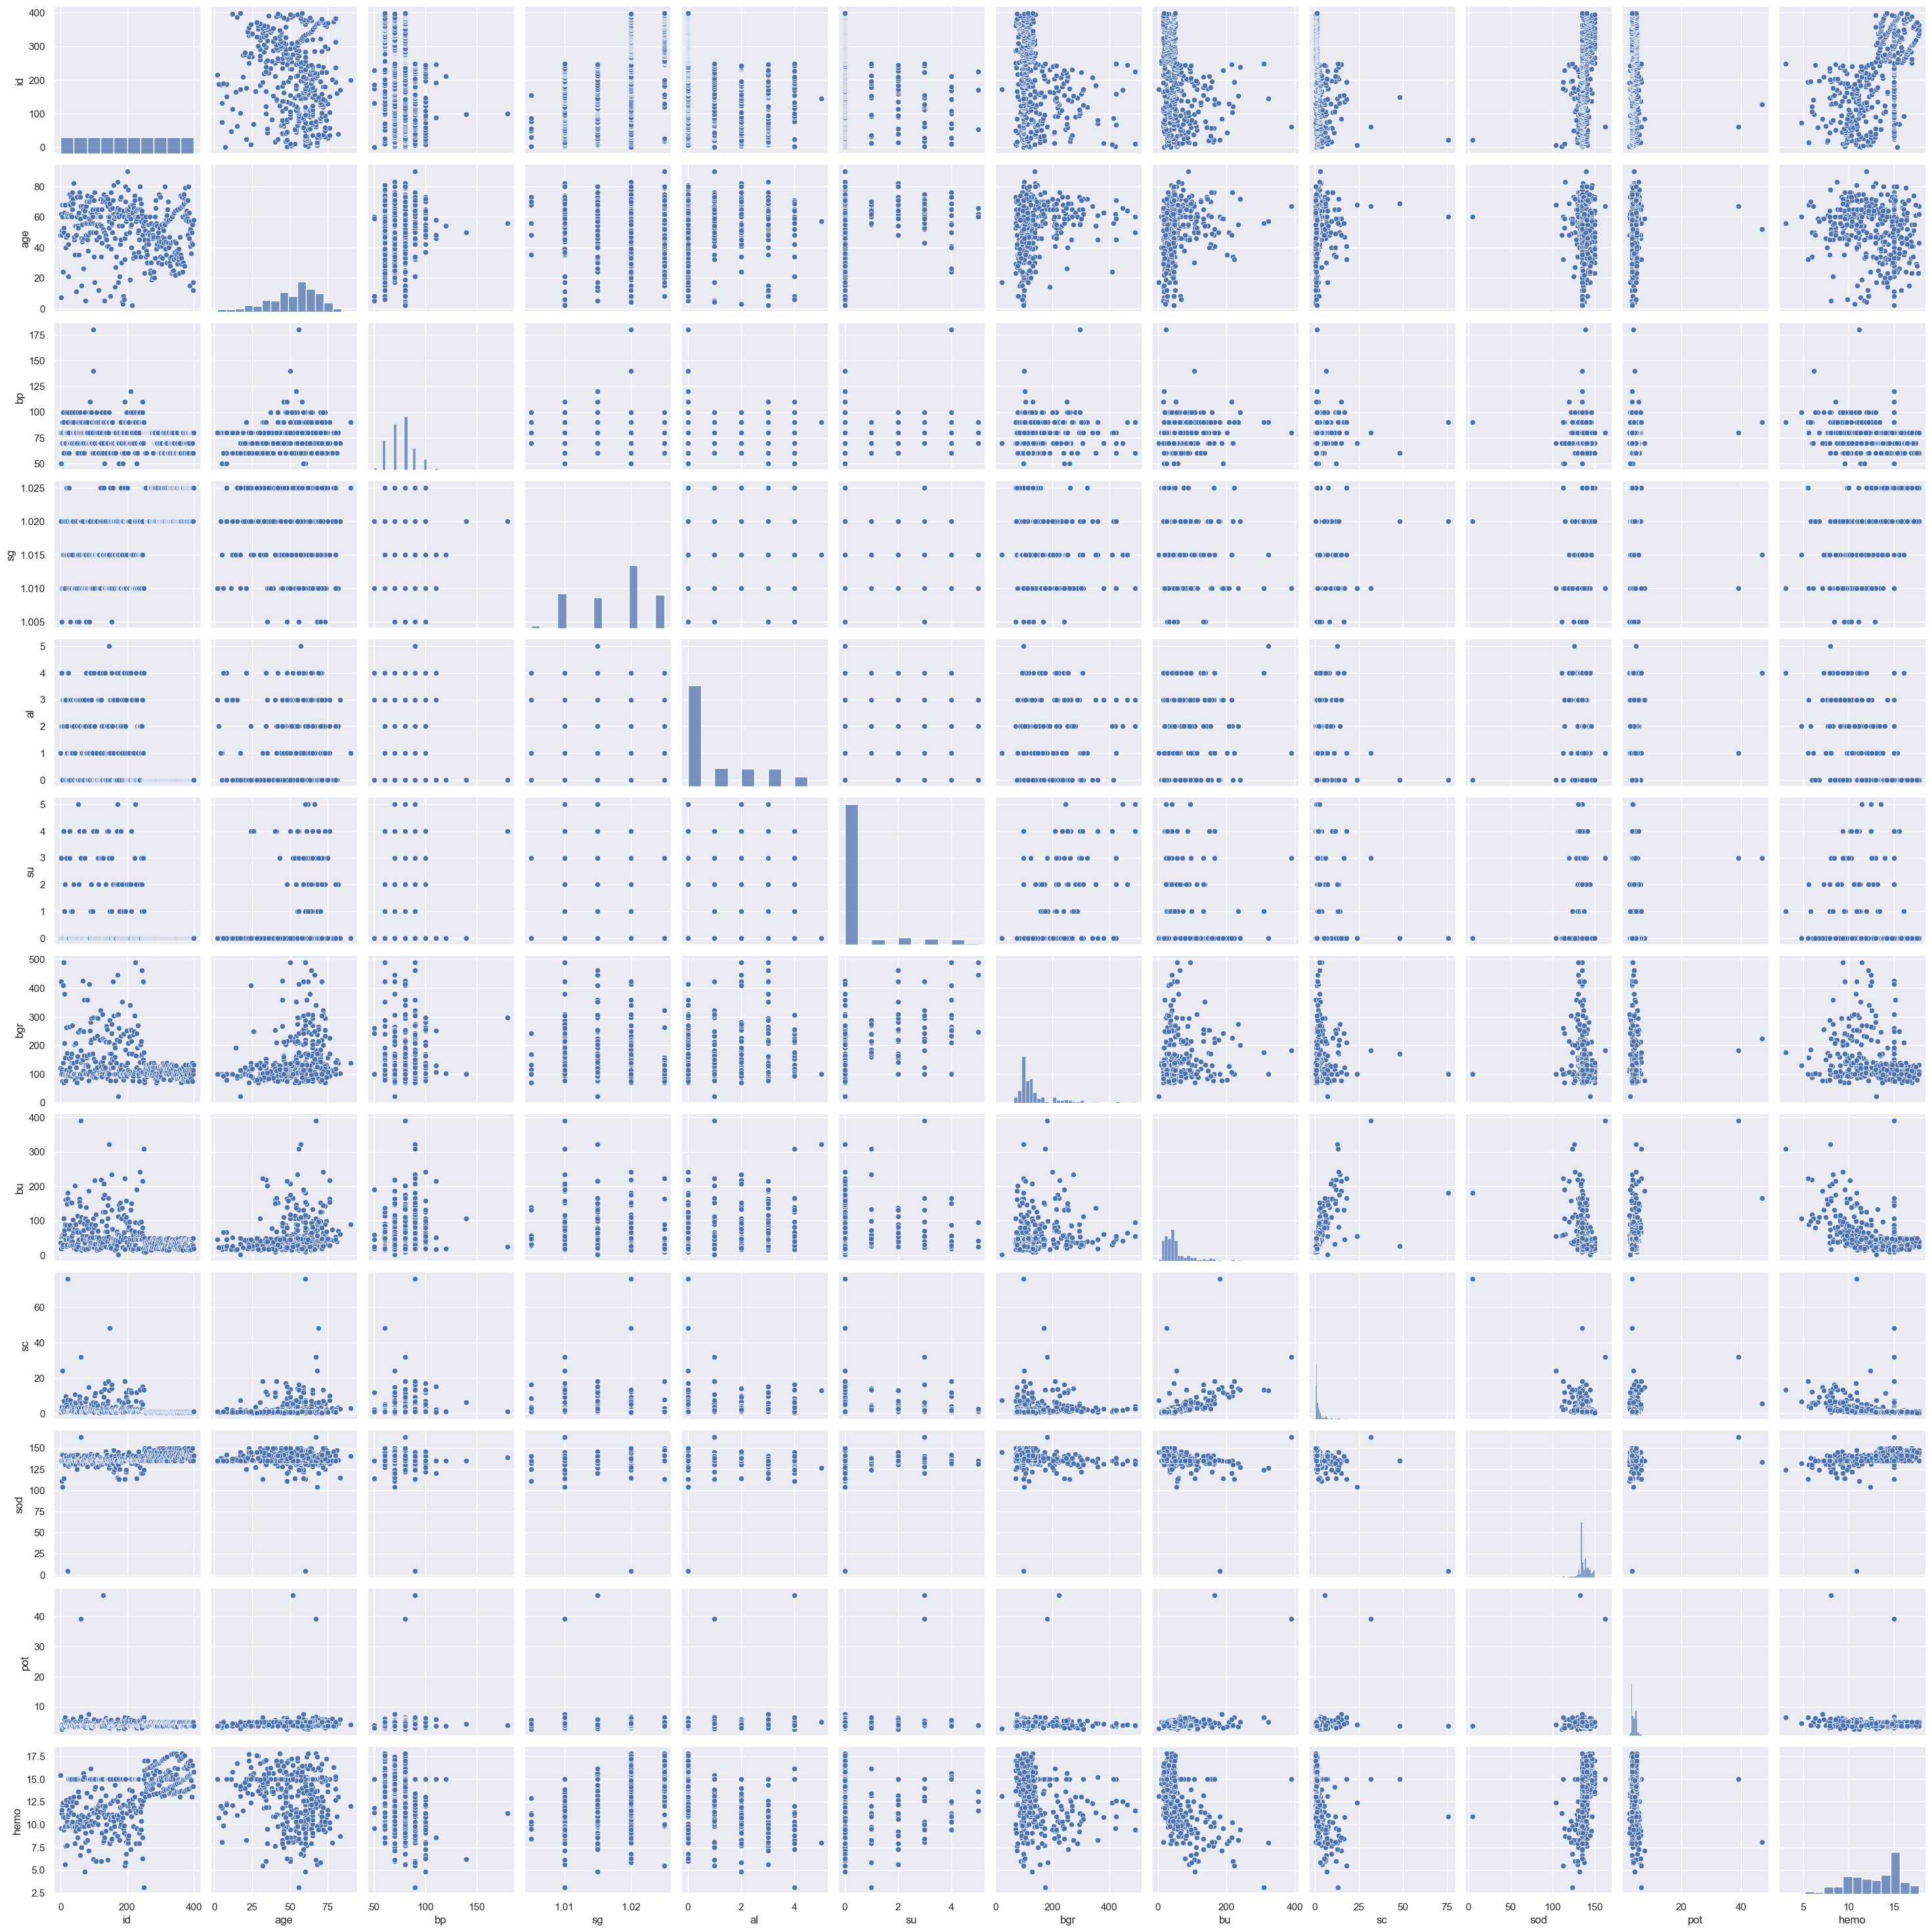

In [11]:
sns.pairplot(df_imputed)

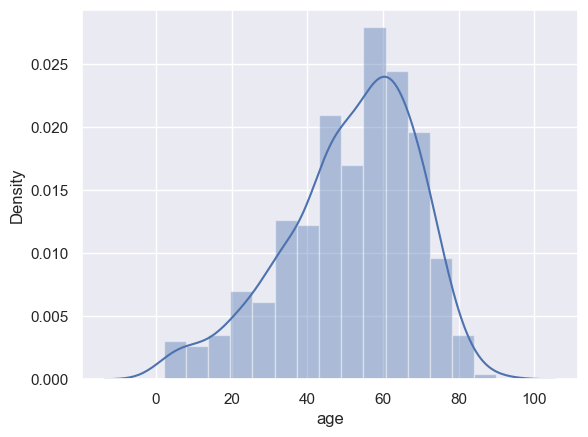

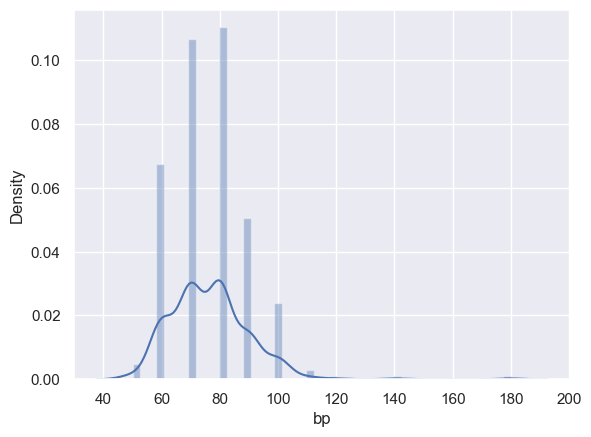

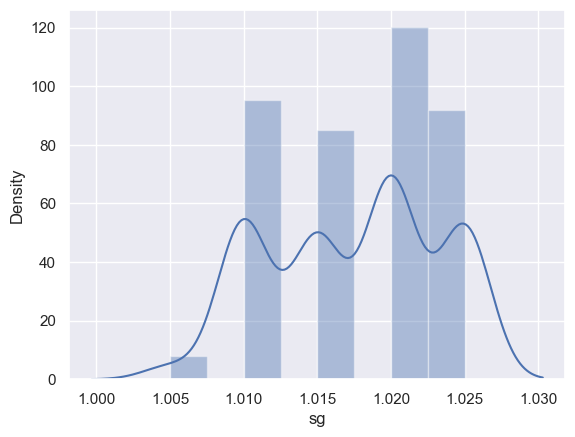

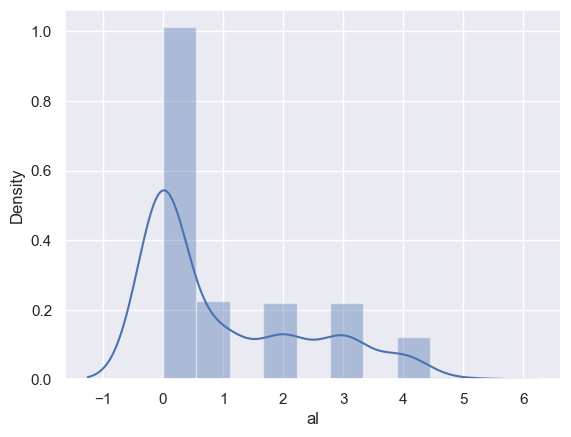

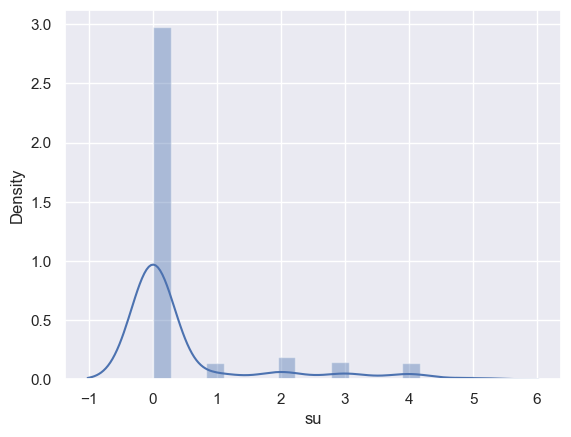

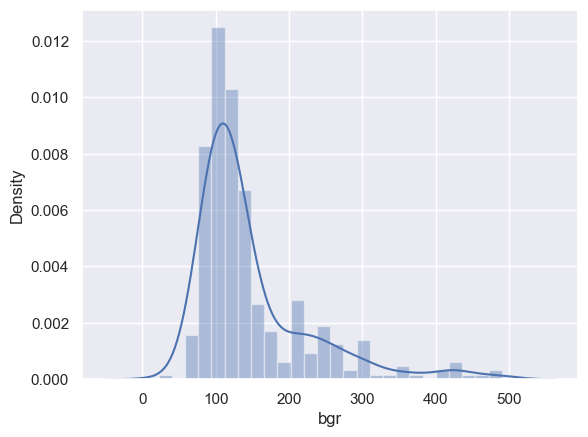

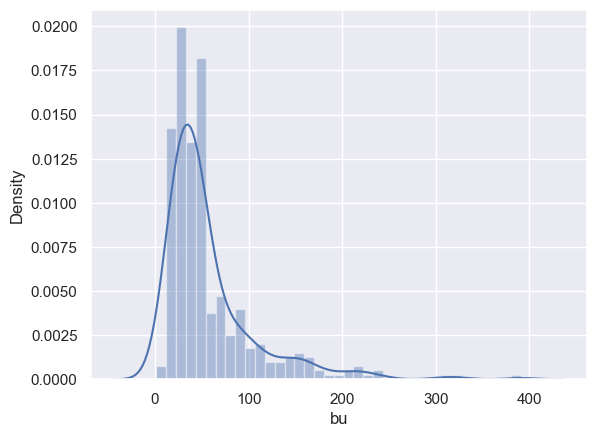

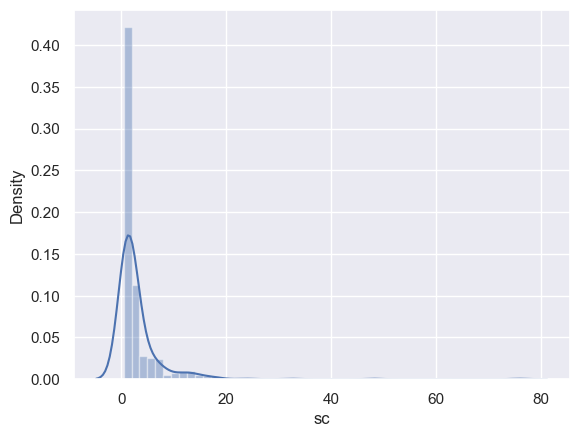

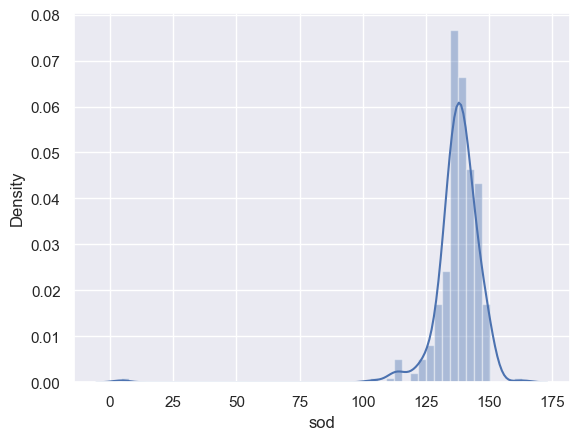

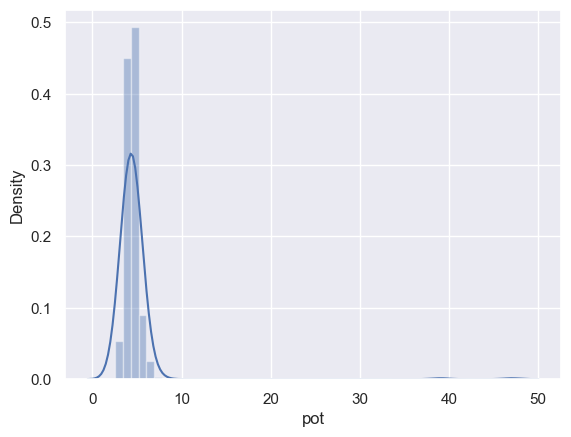

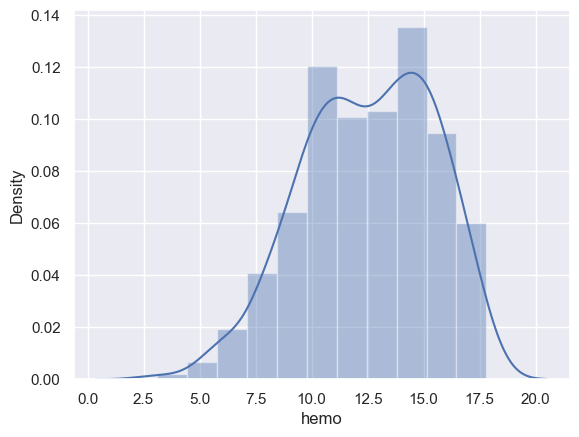

In [16]:
# Find the distribution of data

def distplots(col):
    sns.distplot(df[col])
    plt.show()
    
for i in list(df_imputed.select_dtypes(exclude=["object"]).columns)[1:]:
    distplots(i)

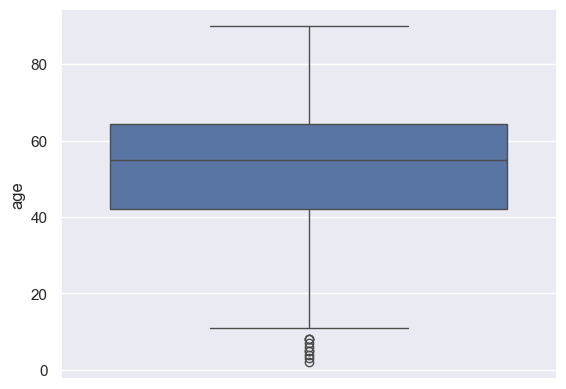

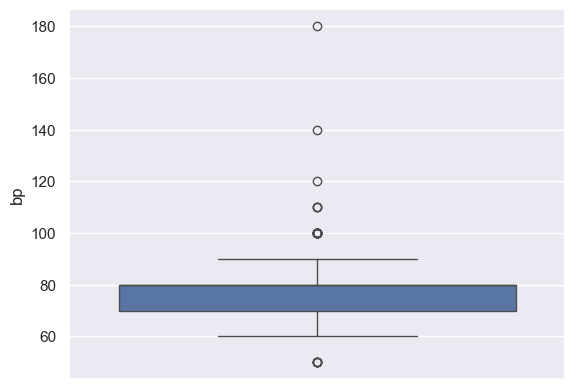

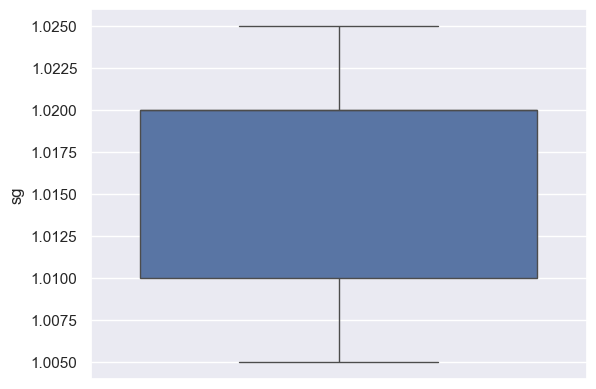

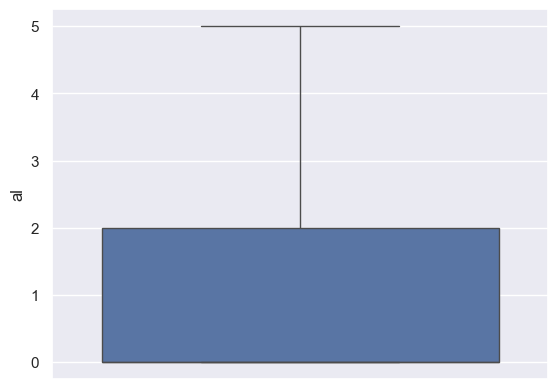

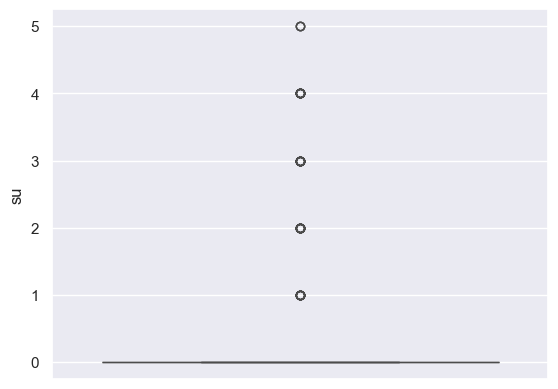

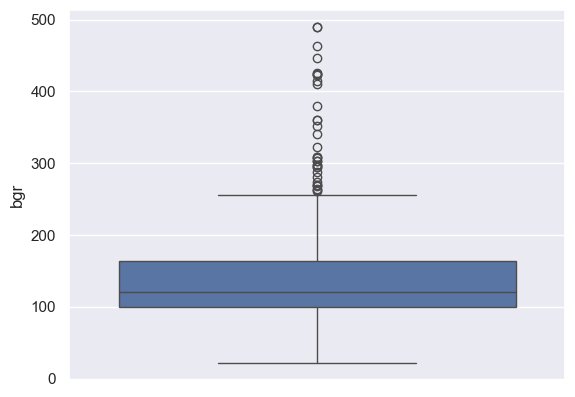

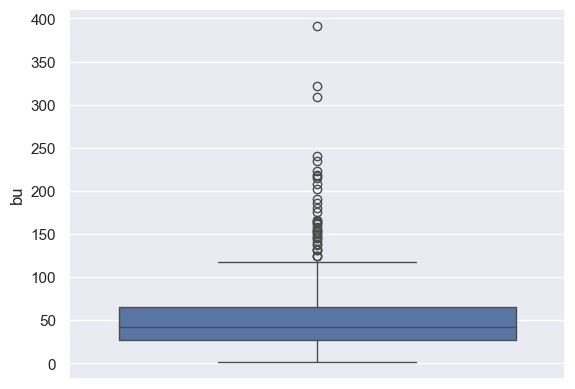

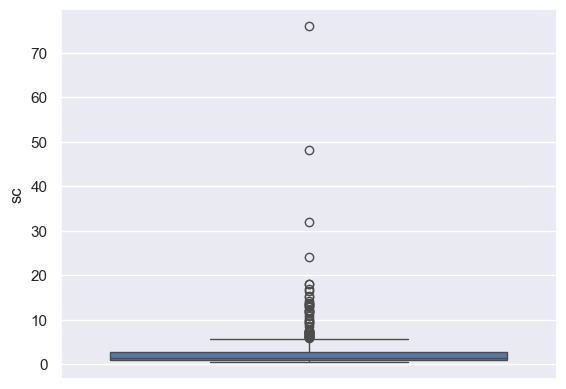

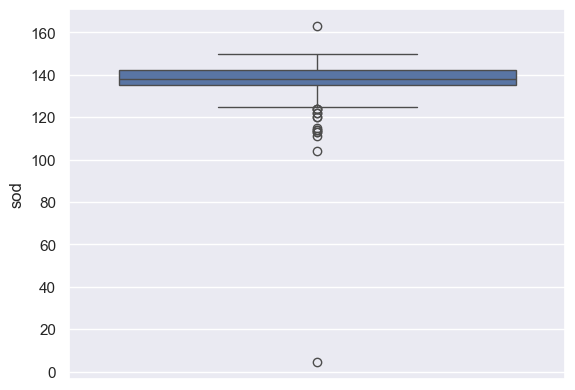

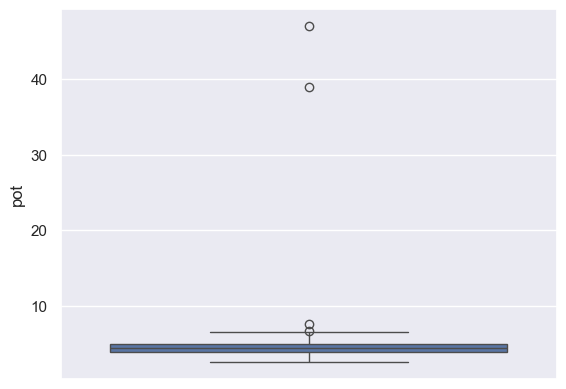

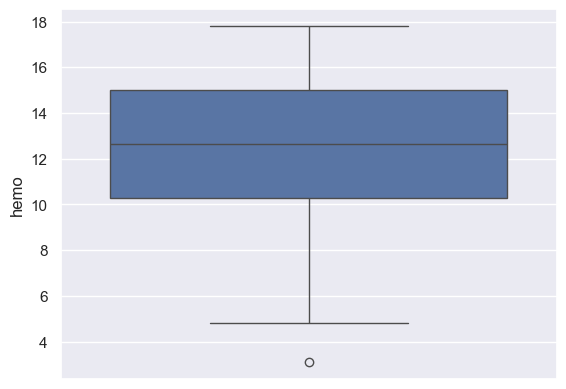

In [17]:
# Find and remove outliers of data

def boxplots(col):
    sns.boxplot(df[col])
    plt.show()
    
for i in list(df_imputed.select_dtypes(exclude=["object"]).columns)[1:]:
    boxplots(i)

In [18]:
# Label encoding to convert categorical values to numerical
from sklearn import preprocessing

df_enco=df_imputed.apply(preprocessing.LabelEncoder().fit_transform)
df_enco

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

<Axes: >

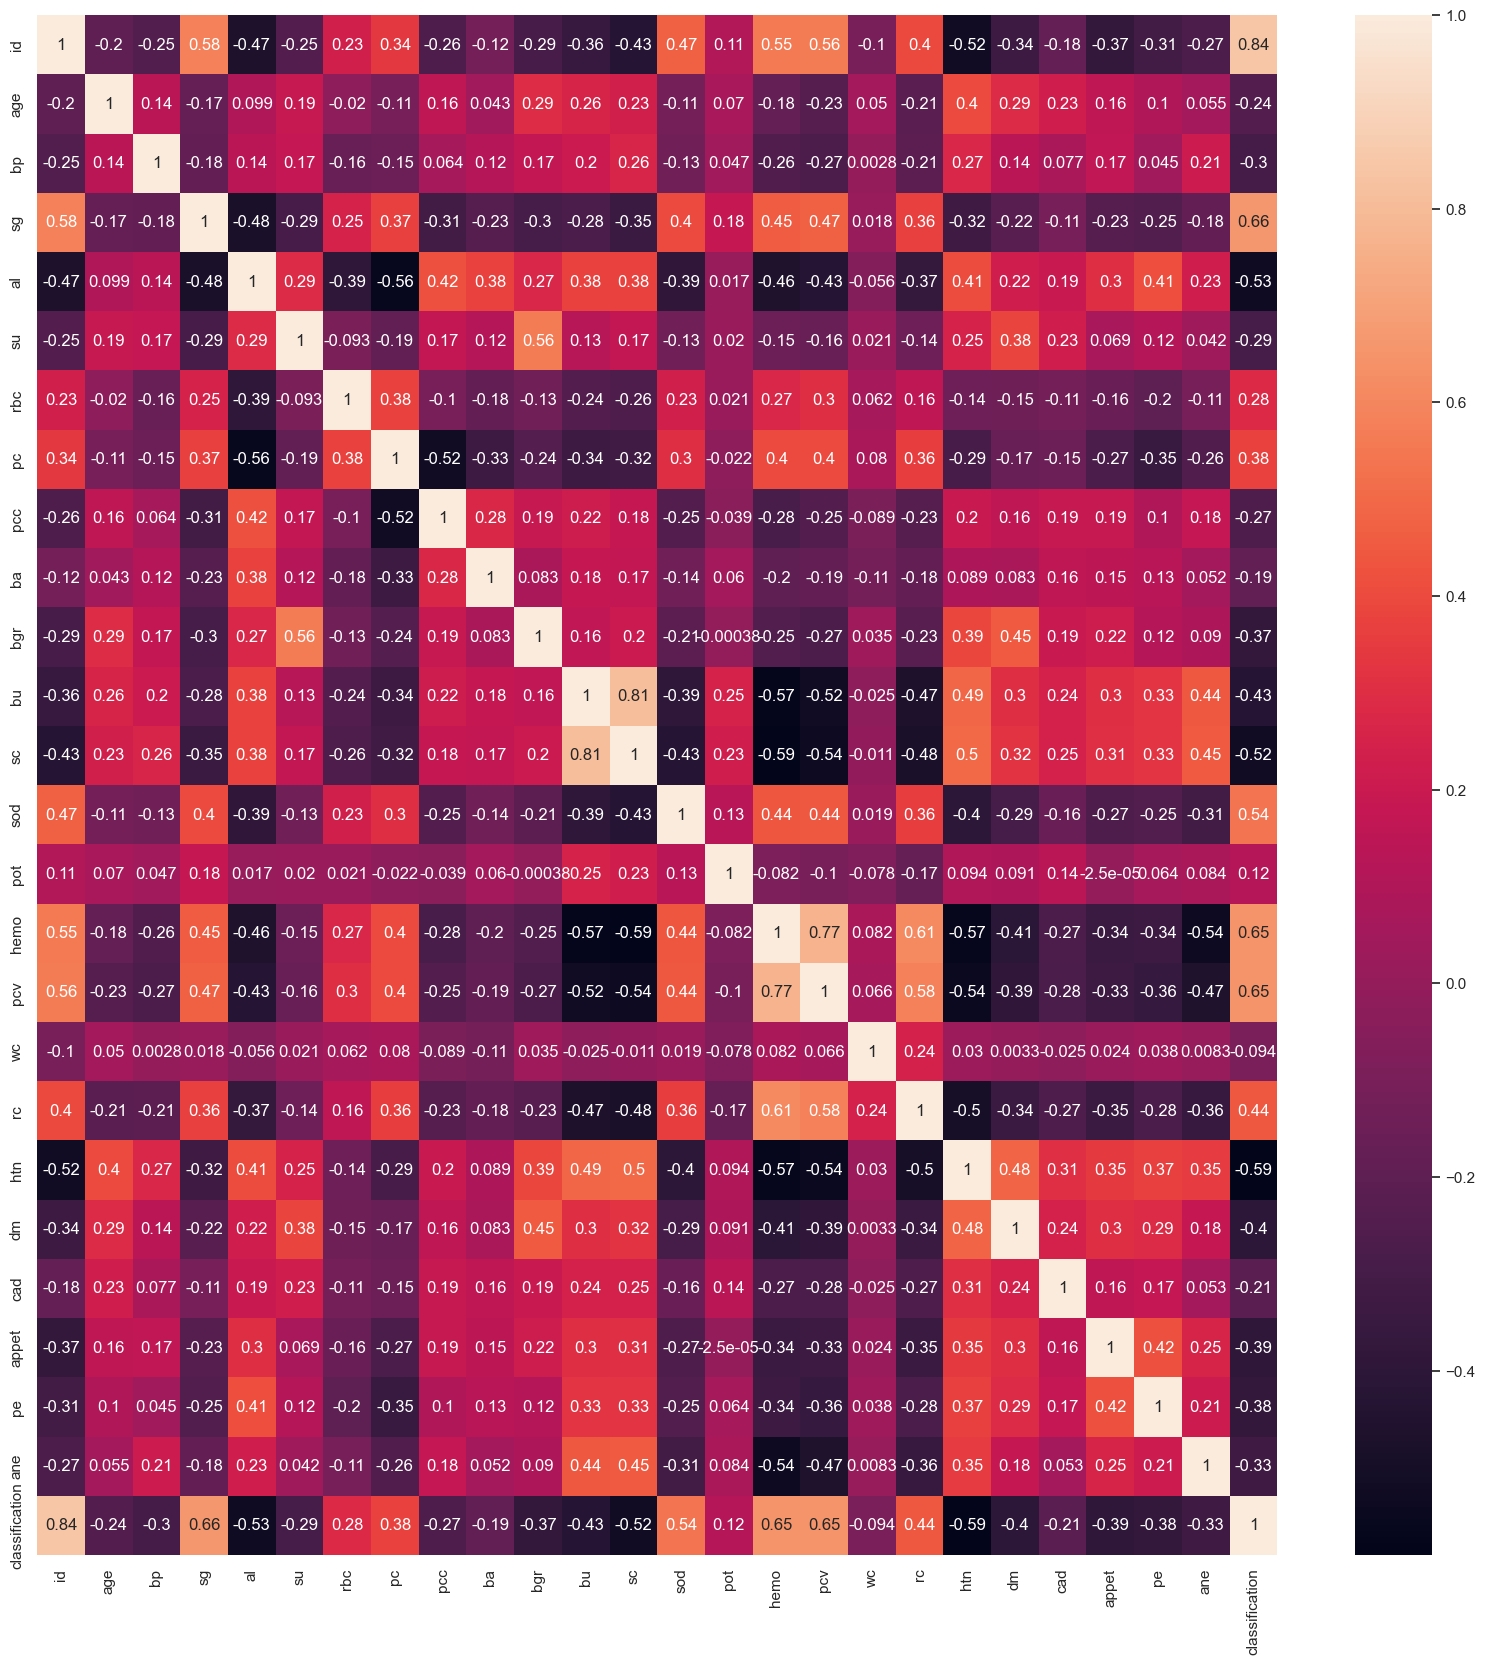

In [19]:
# Finding Correlations

plt.figure(figsize=(20,20))
corr=df_enco.corr()
sns.heatmap(corr,annot=True)

In [20]:
# Lets make some final changes to the data 

# Seperate independent and dependent variables and drop the ID column
x=df_enco.drop(["id","classification"],axis=1)
y=df_enco["classification"]

In [21]:
# Lets detect the label balance
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

print(Counter(y))

Counter({0: 250, 1: 150})


In [22]:
# Lets balance the labels

ros = RandomOverSampler()

X_ros, y_ros = ros.fit_resample(x, y)
print(Counter(y_ros))

Counter({0: 250, 1: 250})


In [23]:
#Initialize a MinMaxScaler and scale the features to between -1 and 1 to normalize them. 
#The MinMaxScaler transforms features by scaling them to a given range.
#The fit_transform() method fits to the data and then transforms it. We don’t need to scale the labels.
#Scale the features to between -1 and 1

# Scaling is important in the algorithms such as support vector machines (SVM) and k-nearest neighbors (KNN) where distance 
# between the data points is important.

scaler=MinMaxScaler((-1,1))
x=scaler.fit_transform(X_ros)
y=y_ros

In [24]:
# Applying PCA 

# The code below has .95 for the number of components parameter. 
# It means that scikit-learn choose the minimum number of principal components such that 95% of the variance is retained.

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.decomposition import PCA

pca = PCA(.95)
X_PCA=pca.fit_transform(x)

print(x.shape)
print(X_PCA.shape)

# Thus we need 18 columns to keep 95% of the variance

(500, 24)
(500, 18)


In [26]:
# Now we will apply LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#‘svd’: Singular value decomposition (default). 
# Does not compute the covariance matrix, therefore this solver is recommended for data with a large number of features.

lda = LDA('svd')
X_LDA = lda.fit_transform(x,y)

print(x.shape)
print(X_LDA.shape)

(500, 24)
(500, 1)


In [73]:
# We will now split both the above feature engineered arrays to train and test and apply our algorithms on both


In [27]:
# With PCA

#Now,split the dataset into training and testing sets keeping 20% of the data for testing.
#Split the dataset
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(X_PCA, y, test_size=0.2, random_state=7)

                       Method Used  Accuracy
0              Logistic Regression      0.98
1                     Decison Tree      0.99
2  Random Forest(information gain)      0.99
3           Random Forest(Entropy)      0.99
4                              SVM      0.99
5                              KNN      0.99
6                              gnb      0.99
7                              bnb      0.91
8                voting classifier      0.99
Axes(0.125,0.11;0.775x0.77)


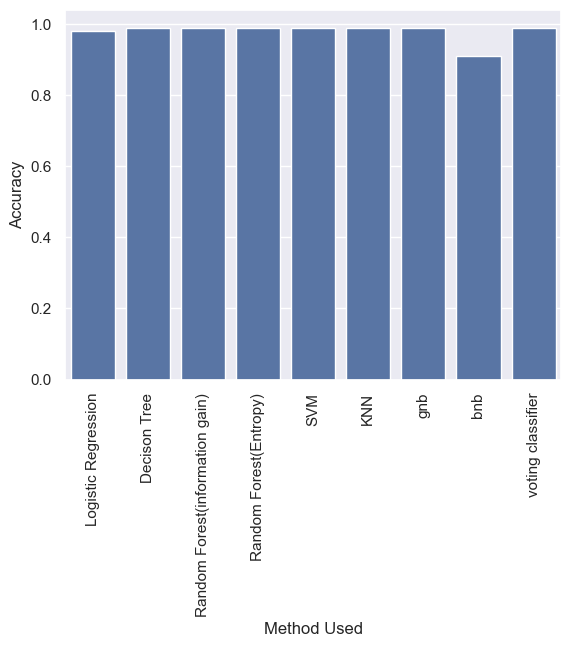

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

list_met=[]
list_accuracy=[]

# Applying all the algorithms

# Apply Logistic Regression
classifier = LogisticRegression(C=0.4,max_iter=1000,solver='liblinear')
lr=classifier.fit(x_train, y_train)
#Preciction
y_pred = classifier.predict(x_test)
#Accuracy
accuracy_LR= accuracy_score(y_test, y_pred)


# Apply Decison Tree
classifier2 = DecisionTreeClassifier(random_state=14)
dt=classifier2.fit(x_train, y_train)
#Preciction
y_pred2 = classifier2.predict(x_test)
#Accuracy
accuracy_DT= accuracy_score(y_test, y_pred2)

# Apply Random Forest criteria=information gain
classifier3 = RandomForestClassifier(random_state=14)
rfi=classifier3.fit(x_train, y_train)
#Preciction
y_pred3 = classifier3.predict(x_test)
#Accuracy
accuracy_RFI= accuracy_score(y_test, y_pred3)

# Apply Random Forest criteria=entropy
classifier4 = RandomForestClassifier(criterion='entropy')
rfe=classifier4.fit(x_train, y_train)
#Preciction
y_pred4 = classifier4.predict(x_test)
#Accuracy
accuracy_RFE= accuracy_score(y_test, y_pred4)

# similarly apply SVM
model_svm = SVC(cache_size=100)
svm=model_svm.fit(x_train, y_train)
#Preciction
y_pred5 = model_svm.predict(x_test)
#Accuracy
accuracy_svc= accuracy_score(y_test, y_pred5)

# Apply KNN
model_knn3 = KNeighborsClassifier(n_neighbors=3)
knn=model_knn3.fit(x_train,y_train)
# Predicting Test Set N=3
pred_knn3= model_knn3.predict(x_test)
#Accuracy
accuracy_SVM = accuracy_score(y_test, pred_knn3)

#Apply Gaussian Naive Bayes
gnb = GaussianNB()
gnb=gnb.fit(x_train, y_train)
# Predicting Test Set
pred_gnb = gnb.predict(x_test)
#accuracy
accuracy_GNB = accuracy_score(y_test, pred_gnb)

#Apply Bernoulli Naive Bayes
model = BernoulliNB()
bnb=model.fit(x_train, y_train)
# Predicting Test Set
pred_bnb = model.predict(x_test)
#accuracy
accuracy_BNB = accuracy_score(y_test, pred_bnb)

# Combining all the above using voting classifier
evc=VotingClassifier(estimators=[('lr', lr), ('rfi', rfi),('rfe', rfe), ('DT', dt),
                                 ('svm',svm),('knn',knn),('gnb',gnb),('bnb',bnb)],voting='hard',
                                 flatten_transform=True)

model_evc=evc.fit(x_train, y_train)
# Predicting Test Set
pred_evc = evc.predict(x_test)
#accuracy
accuracy_evc = accuracy_score(y_test, pred_gnb)

list1=['Logistic Regression','Decison Tree','Random Forest(information gain)','Random Forest(Entropy)','SVM','KNN','gnb','bnb','voting classifier']

list2=[accuracy_LR,accuracy_DT,accuracy_RFI,accuracy_RFE,accuracy_svc,accuracy_SVM,accuracy_GNB,accuracy_BNB,accuracy_evc]
list3=[classifier,classifier2,classifier3,classifier4,model_svm,model_knn3,gnb,model]

df_Accuracy=pd.DataFrame({'Method Used':list1,'Accuracy': list2})
print(df_Accuracy)

chart=sns.barplot(x='Method Used',y='Accuracy',data=df_Accuracy)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
print(chart)



In [29]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay, f1_score, confusion_matrix

# to plot ROC curve
def plot_roc(model, X_test, y_test):
    # calculate the fpr and tpr for all thresholds of the classification
    probabilities = model.predict_proba(np.array(X_test))
    predictions = probabilities
    fpr, tpr, threshold = roc_curve(y_test, predictions[:,1])
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

----------------- Model Performance for  LogisticRegression(C=0.4, max_iter=1000, solver='liblinear')  with PCA ----------

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        48
           1       0.96      1.00      0.98        52

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100


Confusion Matrix:
[[46  2]
 [ 0 52]]

------------------ROC FOR  Logistic Regression  +PCA ---------------------------


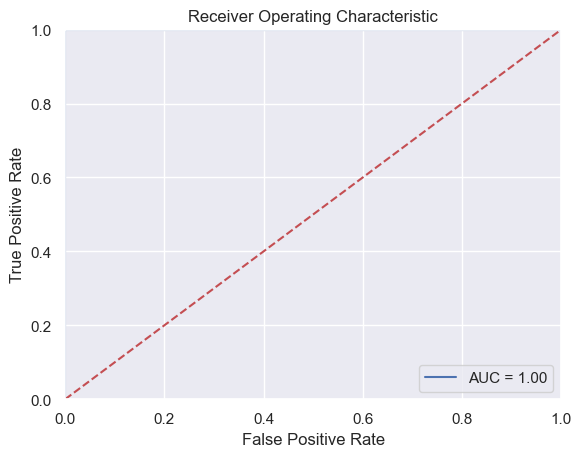


----------------- Model Performance for  DecisionTreeClassifier(random_state=14)  with PCA ----------

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[47  1]
 [ 0 52]]

------------------ROC FOR  Decison Tree  +PCA ---------------------------


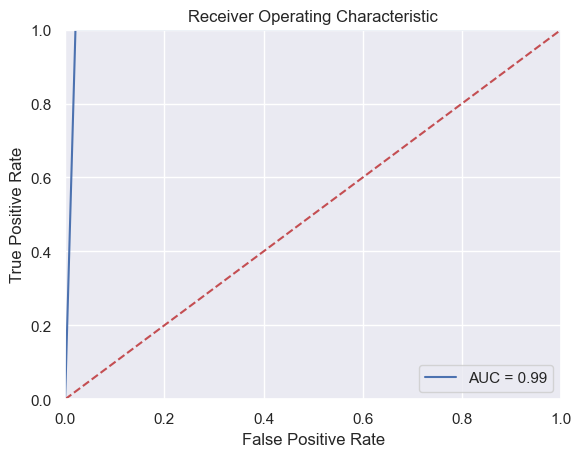


----------------- Model Performance for  RandomForestClassifier(random_state=14)  with PCA ----------

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[47  1]
 [ 0 52]]

------------------ROC FOR  Random Forest(information gain)  +PCA ---------------------------


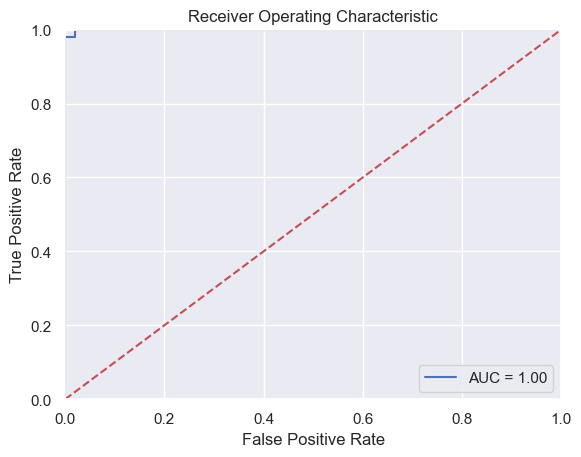


----------------- Model Performance for  RandomForestClassifier(criterion='entropy')  with PCA ----------

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[47  1]
 [ 0 52]]

------------------ROC FOR  Random Forest(Entropy)  +PCA ---------------------------


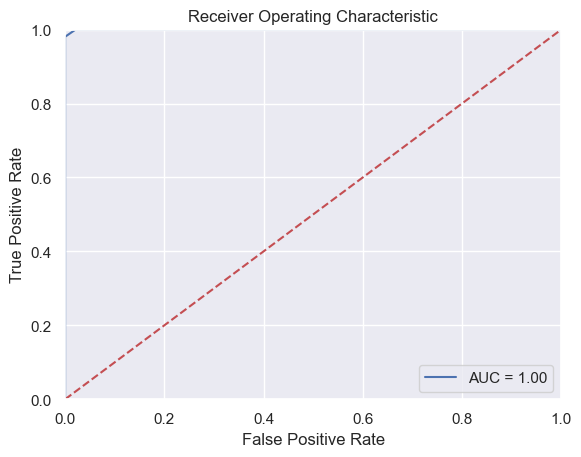


----------------- Model Performance for  SVC(cache_size=100)  with PCA ----------

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[47  1]
 [ 0 52]]

------------------ROC FOR  SVM  +PCA ---------------------------
roc not valid
----------------- Model Performance for  KNeighborsClassifier(n_neighbors=3)  with PCA ----------

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[47  1]
 [ 0 52]]

------

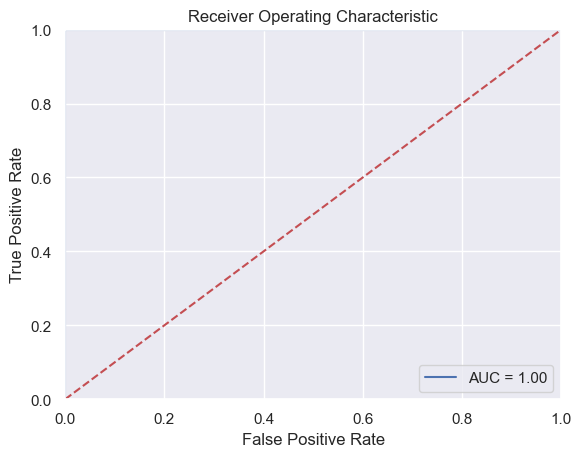


----------------- Model Performance for  GaussianNB()  with PCA ----------

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[47  1]
 [ 0 52]]

------------------ROC FOR  gnb  +PCA ---------------------------


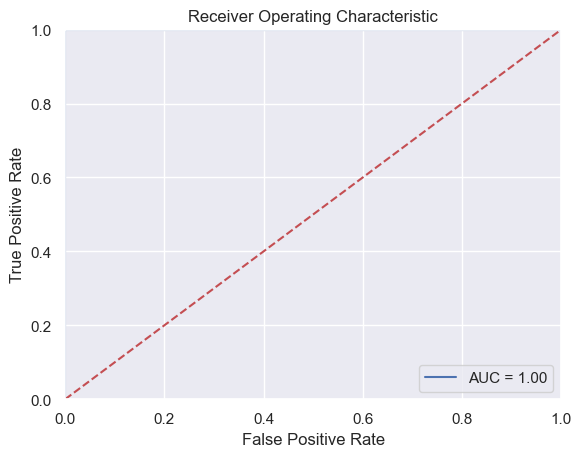


----------------- Model Performance for  BernoulliNB()  with PCA ----------

              precision    recall  f1-score   support

           0       0.85      0.98      0.91        48
           1       0.98      0.85      0.91        52

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100


Confusion Matrix:
[[47  1]
 [ 8 44]]

------------------ROC FOR  bnb  +PCA ---------------------------


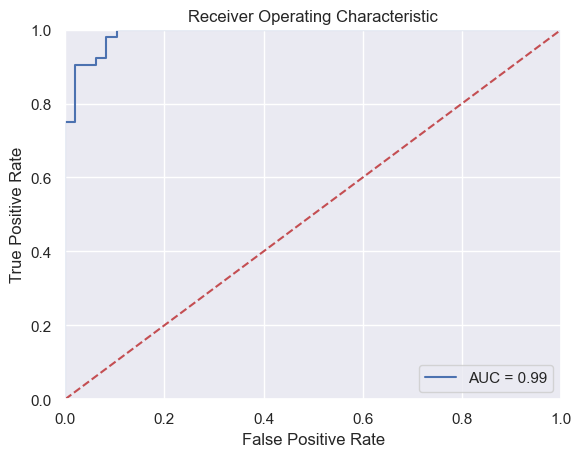

In [30]:
for i in range(0,len(list3)):
    try:
        print("----------------- Model Performance for ",list3[i]," with PCA ----------")
        print()
        print(classification_report(y_test, list3[i].predict(x_test)))
        print()
        print('Confusion Matrix:')
        print(confusion_matrix(y_test, list3[i].predict(x_test)))
        print()
        print("------------------ROC FOR ",list1[i]," +PCA ---------------------------")
        plot_roc(list3[i], x_test, np.array(y_test))
        print()
    except:
        print("roc not valid")

Detailed classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion Matrix:
[[47  1]
 [ 0 52]]


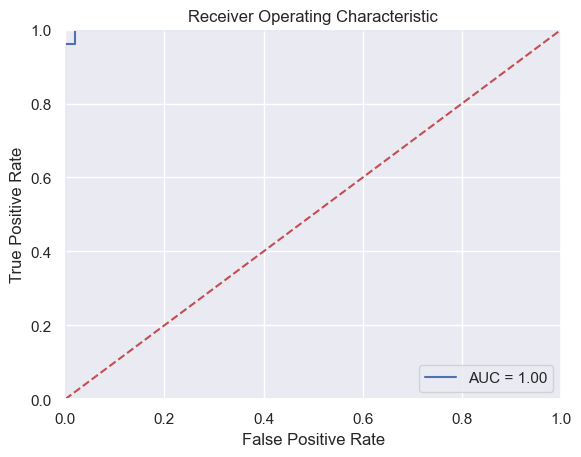

Best parameters:
{'class_weight': None, 'max_depth': 3, 'n_estimators': 9, 'random_state': 42}


In [29]:
# Grid Search CV

from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'n_estimators':[7,8,9,10,11,12,13,14,15,16],'max_depth':[2,3,4,5,6,None],
                     'class_weight':[None,{0: 0.33,1:0.67},'balanced'],'random_state':[42]}]
clf = GridSearchCV(RandomForestClassifier(criterion='entropy'), tuned_parameters, cv=10,scoring='f1')
clf.fit(x_train, y_train)

print("Detailed classification report:")
y_true, lr_pred = y_test, clf.predict(x_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

# Determine the false positive and true positive rates
plot_roc(clf, x_test, np.array(y_test))

print('Best parameters:')
print(clf.best_params_)
clf_best = clf.best_estimator_


              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion Matrix:
[[47  1]
 [ 0 52]]
Accuracy: 0.990000


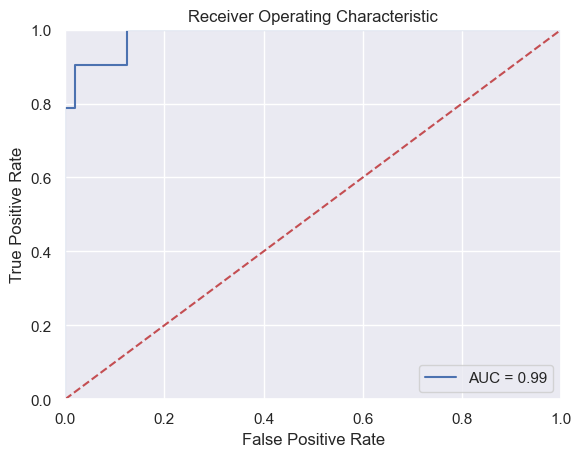

In [30]:
lr_pred = clf_best.predict(x_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

print('Accuracy: %3f' % accuracy_score(y_true, lr_pred))
# Determine the false positive and true positive rates
plot_roc(list3[i], x_test, np.array(y_test))
 


In [80]:
# We will now follow the same steps with LDA and make comparisons

                       Method Used  Accuracy
0              Logistic Regression      0.98
1                     Decison Tree      0.99
2  Random Forest(information gain)      0.99
3           Random Forest(Entropy)      0.99
4                              SVM      0.99
5                              KNN      0.99
6                              gnb      0.99
7                              bnb      0.94
8                voting classifier      0.99
Axes(0.125,0.11;0.775x0.77)


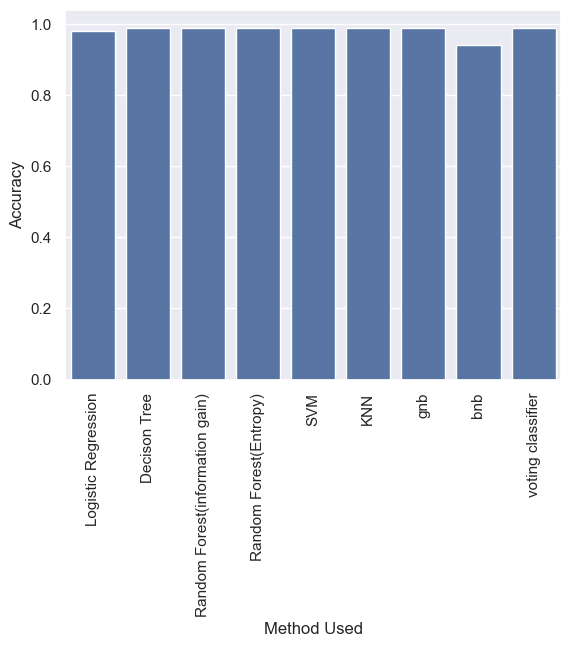

In [31]:
list_met=[]
list_accuracy=[]

# Applying all the algorithms

# Apply Logistic Regression
classifier = LogisticRegression(C=0.4,max_iter=1000,solver='liblinear')
lr=classifier.fit(x_train, y_train)
#Preciction
y_pred = classifier.predict(x_test)
#Accuracy
accuracy_LR= accuracy_score(y_test, y_pred)


# Apply Decison Tree
classifier2 = DecisionTreeClassifier(random_state=14)
dt=classifier2.fit(x_train, y_train)
#Preciction
y_pred2 = classifier2.predict(x_test)
#Accuracy
accuracy_DT= accuracy_score(y_test, y_pred2)

# Apply Random Forest criteria=information gain
classifier3 = RandomForestClassifier(random_state=14)
rfi=classifier3.fit(x_train, y_train)
#Preciction
y_pred3 = classifier3.predict(x_test)
#Accuracy
accuracy_RFI= accuracy_score(y_test, y_pred3)

# Apply Random Forest criteria=entropy
classifier4 = RandomForestClassifier(criterion='entropy')
rfe=classifier4.fit(x_train, y_train)
#Preciction
y_pred4 = classifier4.predict(x_test)
#Accuracy
accuracy_RFE= accuracy_score(y_test, y_pred4)

# similarly apply SVM
model_svm = SVC(cache_size=100)
svm=model_svm.fit(x_train, y_train)
#Preciction
y_pred5 = model_svm.predict(x_test)
#Accuracy
accuracy_svc= accuracy_score(y_test, y_pred5)

# Apply KNN
model_knn3 = KNeighborsClassifier(n_neighbors=3)
knn=model_knn3.fit(x_train,y_train)
# Predicting Test Set N=3
pred_knn3= model_knn3.predict(x_test)
#Accuracy
accuracy_SVM = accuracy_score(y_test, pred_knn3)

#Apply Gaussian Naive Bayes
gnb = GaussianNB()
gnb=gnb.fit(x_train, y_train)
# Predicting Test Set
pred_gnb = gnb.predict(x_test)
#accuracy
accuracy_GNB = accuracy_score(y_test, pred_gnb)

#Apply Bernoulli Naive Bayes
model = BernoulliNB()
bnb=model.fit(x_train, y_train)
# Predicting Test Set
pred_bnb = model.predict(x_test)
#accuracy
accuracy_BNB = accuracy_score(y_test, pred_bnb)

# Combining all the above using voting classifier
evc=VotingClassifier(estimators=[('lr', lr), ('rfi', rfi),('rfe', rfe), ('DT', dt),
                                 ('svm',svm),('knn',knn),('gnb',gnb),('bnb',bnb)],voting='hard',
                                 flatten_transform=True)

model_evc=evc.fit(x_train, y_train)
# Predicting Test Set
pred_evc = evc.predict(x_test)
#accuracy
accuracy_evc = accuracy_score(y_test, pred_gnb)

list1=['Logistic Regression','Decison Tree','Random Forest(information gain)','Random Forest(Entropy)','SVM','KNN','gnb','bnb','voting classifier']

list2=[accuracy_LR,accuracy_DT,accuracy_RFI,accuracy_RFE,accuracy_svc,accuracy_SVM,accuracy_GNB,accuracy_BNB,accuracy_evc]
list3=[classifier,classifier2,classifier3,classifier4,model_svm,model_knn3,gnb,model]

df_Accuracy=pd.DataFrame({'Method Used':list1,'Accuracy': list2})
print(df_Accuracy)

chart=sns.barplot(x='Method Used',y='Accuracy',data=df_Accuracy)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
print(chart)



----------------- Model Performance for  LogisticRegression(C=0.4, max_iter=1000, solver='liblinear')  with LDA ----------

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        48
           1       0.96      1.00      0.98        52

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100


Confusion Matrix:
[[46  2]
 [ 0 52]]

------------------ROC FOR  Logistic Regression  +LDA ---------------------------


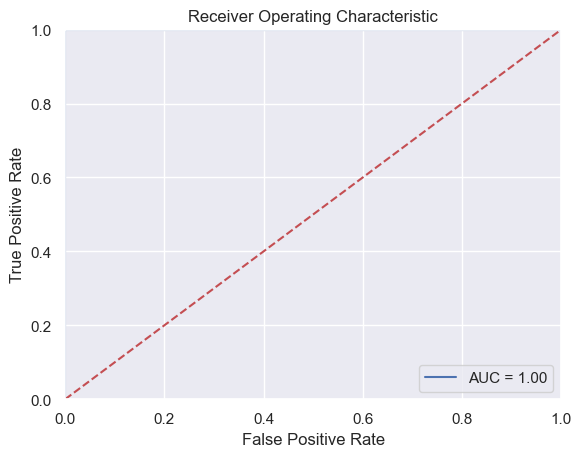


----------------- Model Performance for  DecisionTreeClassifier(random_state=14)  with LDA ----------

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[47  1]
 [ 0 52]]

------------------ROC FOR  Decison Tree  +LDA ---------------------------


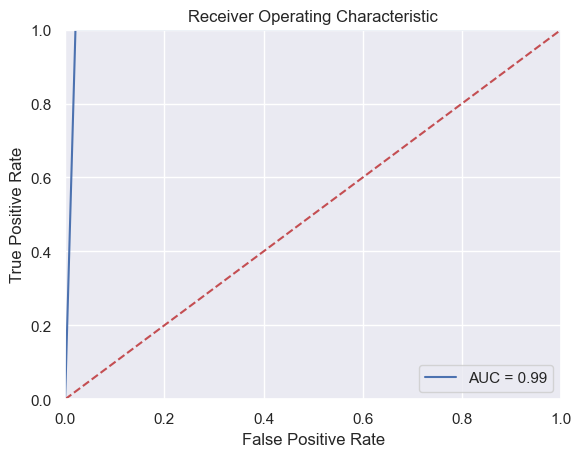


----------------- Model Performance for  RandomForestClassifier(random_state=14)  with LDA ----------

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[47  1]
 [ 0 52]]

------------------ROC FOR  Random Forest(information gain)  +LDA ---------------------------


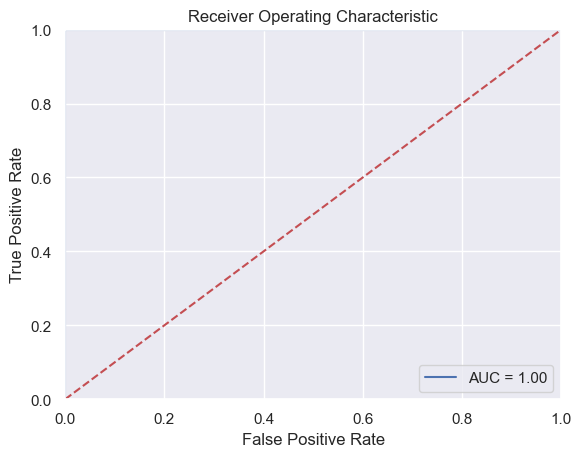


----------------- Model Performance for  RandomForestClassifier(criterion='entropy')  with LDA ----------

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[47  1]
 [ 0 52]]

------------------ROC FOR  Random Forest(Entropy)  +LDA ---------------------------


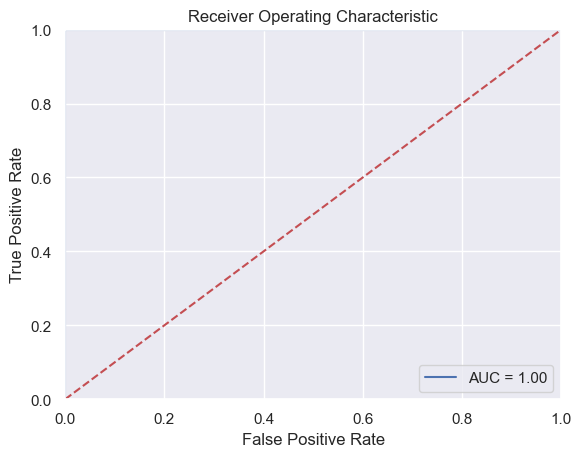


----------------- Model Performance for  SVC(cache_size=100)  with LDA ----------

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[47  1]
 [ 0 52]]

------------------ROC FOR  SVM  +LDA ---------------------------
roc not valid
----------------- Model Performance for  KNeighborsClassifier(n_neighbors=3)  with LDA ----------

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[47  1]
 [ 0 52]]

------

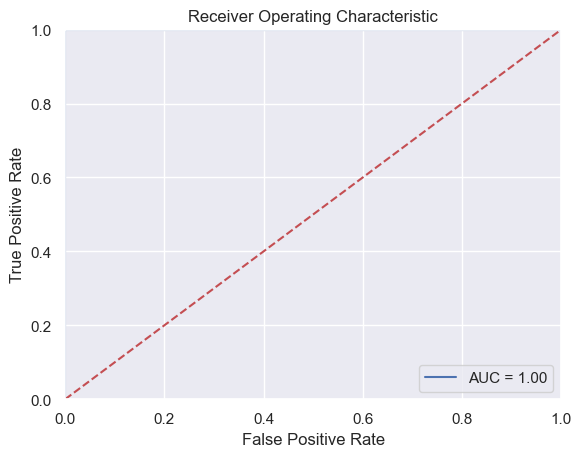


----------------- Model Performance for  GaussianNB()  with LDA ----------

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[47  1]
 [ 0 52]]

------------------ROC FOR  gnb  +LDA ---------------------------


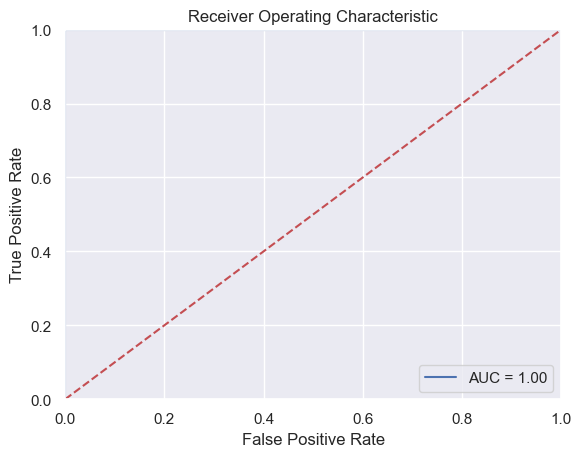


----------------- Model Performance for  BernoulliNB()  with LDA ----------

              precision    recall  f1-score   support

           0       0.90      0.98      0.94        48
           1       0.98      0.90      0.94        52

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100


Confusion Matrix:
[[47  1]
 [ 5 47]]

------------------ROC FOR  bnb  +LDA ---------------------------


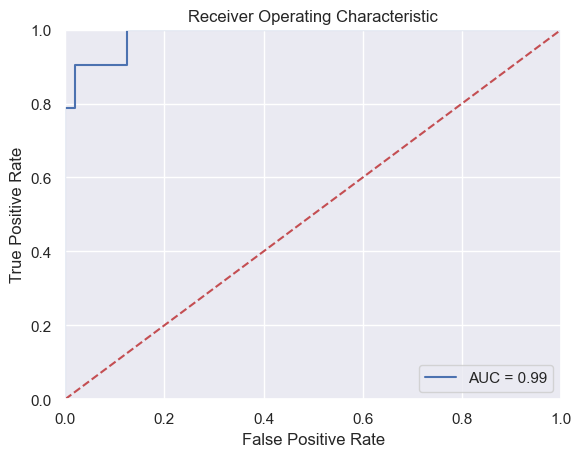

In [32]:
for i in range(0,len(list3)):
    try:
        print("----------------- Model Performance for ",list3[i]," with LDA ----------")
        print()
        print(classification_report(y_test, list3[i].predict(x_test)))
        print()
        print('Confusion Matrix:')
        print(confusion_matrix(y_test, list3[i].predict(x_test)))
        print()
        print("------------------ROC FOR ",list1[i]," +LDA ---------------------------")
        plot_roc(list3[i], x_test, np.array(y_test))
        print()
    except:
        print("roc not valid")

Detailed classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion Matrix:
[[47  1]
 [ 0 52]]


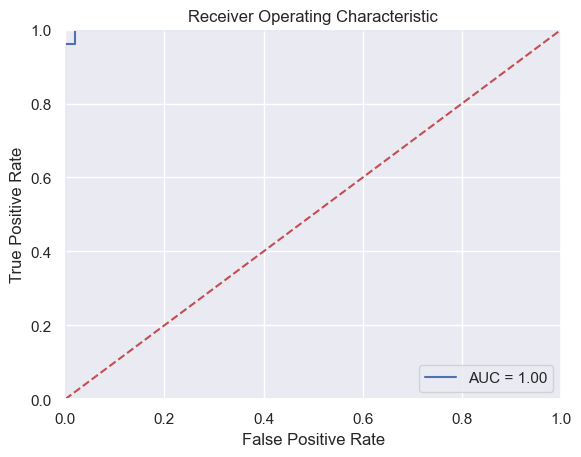

Best parameters:
{'class_weight': None, 'max_depth': 3, 'n_estimators': 9, 'random_state': 42}


In [33]:
# Grid Search CV

from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'n_estimators':[7,8,9,10,11,12,13,14,15,16],'max_depth':[2,3,4,5,6,None],
                     'class_weight':[None,{0: 0.33,1:0.67},'balanced'],'random_state':[42]}]
clf = GridSearchCV(RandomForestClassifier(criterion='entropy'), tuned_parameters, cv=10,scoring='f1')
clf.fit(x_train, y_train)

print("Detailed classification report:")
y_true, lr_pred = y_test, clf.predict(x_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

# Determine the false positive and true positive rates
plot_roc(clf, x_test, np.array(y_test))

print('Best parameters:')
print(clf.best_params_)
clf_best = clf.best_estimator_


              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.98      1.00      0.99        52

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion Matrix:
[[47  1]
 [ 0 52]]
Accuracy: 0.990000


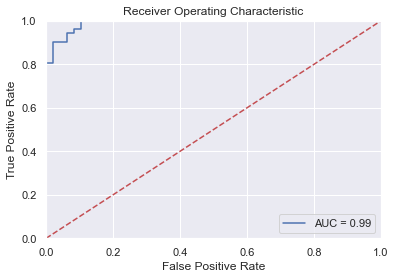

In [84]:
lr_pred = clf_best.predict(x_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

print('Accuracy: %3f' % accuracy_score(y_true, lr_pred))
# Determine the false positive and true positive rates
plot_roc(list3[i], x_test, np.array(y_test))
 


In [85]:
# Now lets try a neural network approach

In [34]:
# With PCA

#Now,split the dataset into training and testing sets keeping 20% of the data for testing.
#Split the dataset
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(X_PCA, y, test_size=0.2, random_state=7)

In [37]:
import keras
# A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
from keras.models import Sequential

# Dense layer is the regular deeply connected neural network layer. It is most common and frequently used layer. Dense layer does the below operation on the input and return the output.
from keras.layers import Dense

# The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. 
from keras.layers import Dropout

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model

# Optimizers are algorithms or methods used to change the attributes of the neural network such as weights and learning rate to reduce the losses. Optimizers are used to solve optimization problems by minimizing the function.
# Adam optimization is an extension to Stochastic gradient decent and can be used in place of classical stochastic gradient descent to update network weights more efficiently.
from keras.optimizers import Adam
from sklearn.model_selection import KFold


In [38]:
# Creating the model

def model():
    
    classifier = Sequential()
    classifier.add(Dense(15, input_shape = (x_train.shape[1],), activation = 'relu'))
    classifier.add(Dropout(0.2))
    classifier.add(Dense(15, activation = 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(Dense(1, activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return classifier

In [39]:
model = model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                285       
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(x_train,y_train,validation_data = (x_test, y_test),epochs = 5,verbose = 1)                  
                      

Epoch 1/5
13/13 [==============================] - 1s 17ms/step - loss: 0.7520 - accuracy: 0.4250 - val_loss: 0.7271 - val_accuracy: 0.5500
Epoch 2/5
13/13 [==============================] - 0s 4ms/step - loss: 0.7149 - accuracy: 0.4825 - val_loss: 0.6933 - val_accuracy: 0.6000
Epoch 3/5
13/13 [==============================] - 0s 5ms/step - loss: 0.6808 - accuracy: 0.5475 - val_loss: 0.6626 - val_accuracy: 0.6700
Epoch 4/5
13/13 [==============================] - 0s 5ms/step - loss: 0.6570 - accuracy: 0.5950 - val_loss: 0.6342 - val_accuracy: 0.7400
Epoch 5/5
13/13 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6700 - val_loss: 0.6065 - val_accuracy: 0.8100


In [41]:
# function to plot the roc_curve
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('classification', auc(fpr, tpr)))
    c_ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve_helper(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    aps = average_precision_score(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('classification', aps))
    c_ax.plot(recall, precision, color='red', lw=2)
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    

# function to plot the history
def plot_history(history):
    f = plt.figure()
    f.set_figwidth(15)
    
    f.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()
    plt.title("Modell Loss")
    
    f.add_subplot(1, 2, 2)
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.legend()
    plt.title("Modell Accuracy")

    plt.show()

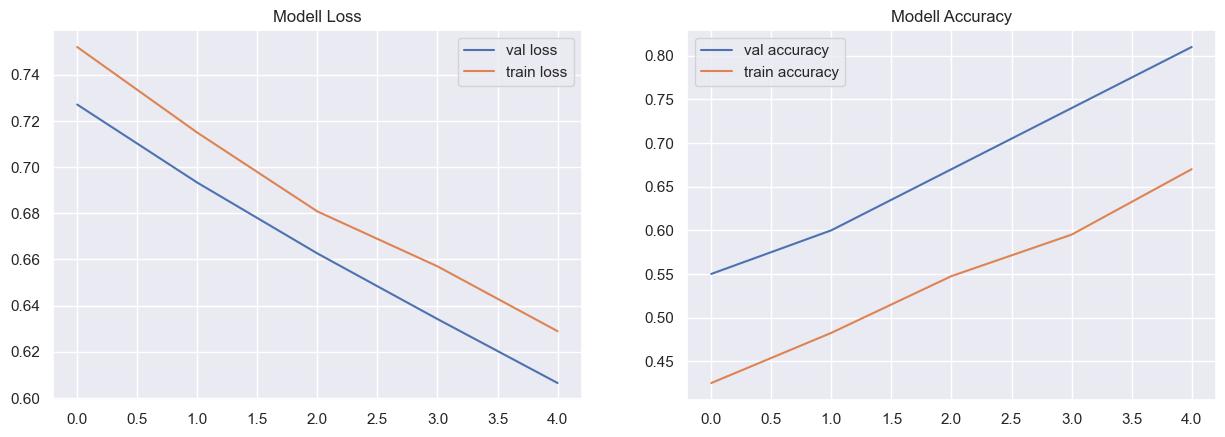

In [42]:
hist = plot_history(history)

4/4 [==============================] - 0s 0s/step


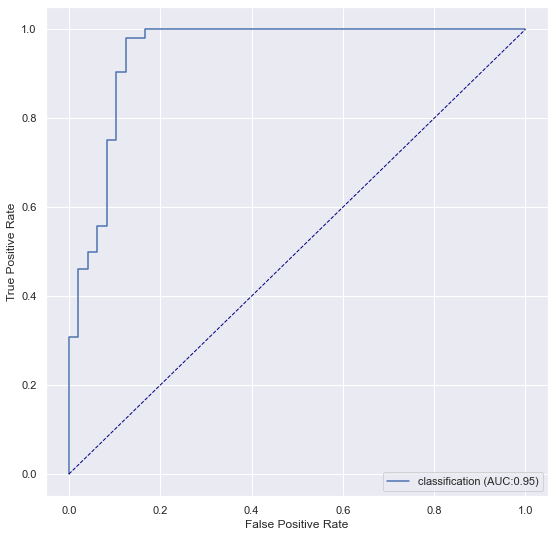

In [93]:
plot_auc(y_test, model.predict(x_test, verbose = True))

4/4 [==============================] - 0s 0s/step


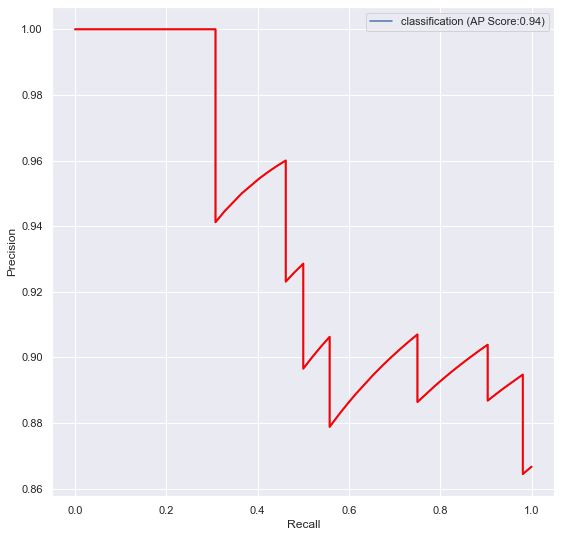

In [94]:
plot_precision_recall_curve_helper(y_test, model.predict(x_test, verbose = True))

In [43]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0

precision, recall, thresholds = precision_recall_curve(y_test, model.predict(x_test, verbose = True))
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
threshold = thresholds[idx]
print('********************************************************************************************************')
print('Precision: '+ str(precision[idx]))
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: ' + str(f1score[idx]))

4/4 [==============================] - 0s 4ms/step
********************************************************************************************************
Precision: 0.896551724137931
Recall: 1.0
Threshold: 0.55480945
F1 Score: 0.9454545454545454


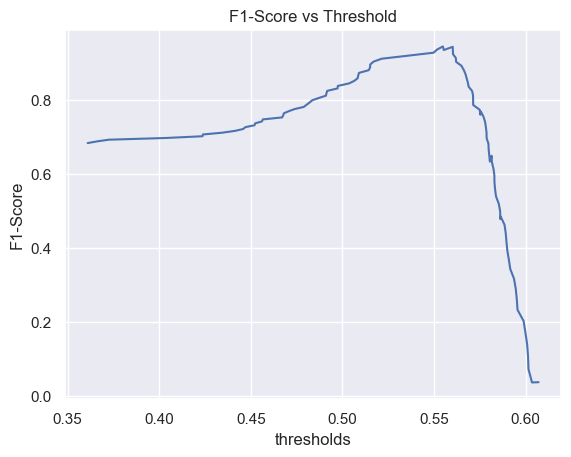

In [44]:
plt.figure()
plt.plot(thresholds, f1score)
plt.title("F1-Score vs Threshold")
plt.xlabel("thresholds")
plt.ylabel("F1-Score")
plt.show()

In [45]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib

# Load dataset
df = pd.read_csv("kidney_disease.csv")

# Clean missing or weird symbols
df.replace(["?", "\t?", " ", ""], np.nan, inplace=True)
df = df.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)

# Clean target column
df['classification'] = df['classification'].astype(str).str.strip().str.lower()
df = df[df['classification'].isin(['ckd', 'notckd'])]
df['classification'] = df['classification'].map({'ckd': 1, 'notckd': 0})

# Categorical mappings
categorical_mappings = {
    'rbc': {'normal': 0, 'abnormal': 1},
    'pc': {'normal': 0, 'abnormal': 1},
    'pcc': {'notpresent': 0, 'present': 1},
    'ba': {'notpresent': 0, 'present': 1},
    'htn': {'no': 0, 'yes': 1},
    'dm': {'no': 0, 'yes': 1, ' yes': 1, '\tno': 0, '\tyes': 1},
    'cad': {'no': 0, 'yes': 1, '\tno': 0},
    'appet': {'good': 1, 'poor': 0},
    'pe': {'no': 0, 'yes': 1},
    'ane': {'no': 0, 'yes': 1}
}
for col, mapping in categorical_mappings.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)

# Convert all to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# ✅ Final feature list (25 features)
features = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba',
            'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc',
            'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
X = df[features]
y = df['classification']

# Drop rows where target is NaN
X = X[~y.isna()]
y = y[~y.isna()]

# Impute missing values
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = MinMaxScaler((-1, 1))
X_scaled = scaler.fit_transform(X_imputed)

# Train model
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Save model
joblib.dump(model, "classifier.pkl")
print("✅ Model trained and saved as classifier.pkl")

# Optionally save imputer and scaler
joblib.dump(imputer, "imputer.pkl")
joblib.dump(scaler, "scaler.pkl")


✅ Model trained and saved as classifier.pkl


['scaler.pkl']

In [34]:
%%writefile app.py
from flask import Flask, render_template, request, redirect, send_file
import pandas as pd
import numpy as np
import joblib
import os

app = Flask(__name__)



# Load model, imputer, and scaler
model = joblib.load("classifier.pkl")
imputer = joblib.load("imputer.pkl")
scaler = joblib.load("scaler.pkl")

# Feature and categorical mapping
FEATURES = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba',
            'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc',
            'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

categorical_mappings = {
    'rbc': {'normal': 0, 'abnormal': 1},
    'pc': {'normal': 0, 'abnormal': 1},
    'pcc': {'notpresent': 0, 'present': 1},
    'ba': {'notpresent': 0, 'present': 1},
    'htn': {'no': 0, 'yes': 1},
    'dm': {'no': 0, 'yes': 1, ' yes': 1, '\tno': 0, '\tyes': 1},
    'cad': {'no': 0, 'yes': 1, '\tno': 0},
    'appet': {'good': 1, 'poor': 0},
    'pe': {'no': 0, 'yes': 1},
    'ane': {'no': 0, 'yes': 1}
}

def preprocess_input(data):
    for col in FEATURES:
        if col not in data.columns:
            data[col] = np.nan
    for col, mapping in categorical_mappings.items():
        if col in data.columns:
            data[col] = data[col].map(mapping)

    data = data.apply(pd.to_numeric, errors='coerce')
    data = data[FEATURES]

    imputed = imputer.transform(data)
    scaled = scaler.transform(imputed)
    return scaled

@app.route("/", methods=["GET", "POST"])
def index():
    prediction = None
    probability = None

    if request.method == "POST" and "predict_single" in request.form:
        input_data = {col: request.form.get(col) for col in FEATURES}
        input_df = pd.DataFrame([{
    k: (v if v.strip() != "" else np.nan) for k, v in input_data.items()
}])
        processed = preprocess_input(input_df)
        prediction = model.predict(processed)[0]
        probability = model.predict_proba(processed)[0][1]

    return render_template("index.html", features=FEATURES, prediction=prediction, probability=probability)

@app.route("/predict_csv", methods=["POST"])
def predict_csv():
    file = request.files["csv_file"]
    if file:
        df = pd.read_csv(file)
        processed = preprocess_input(df)
        preds = model.predict(processed)
        df["Prediction"] = ["CKD" if p == 1 else "No CKD" for p in preds]
        result_file = "bulk_predictions.csv"
        df.to_csv(result_file, index=False)
        return send_file(result_file, as_attachment=True)

    return redirect("/")

if __name__ == "__main__":
    app.run(host='0.0.0.0', port=int(os.environ.get("PORT", 5000)))

Overwriting app.py
